Selected Image: 28_training.tif


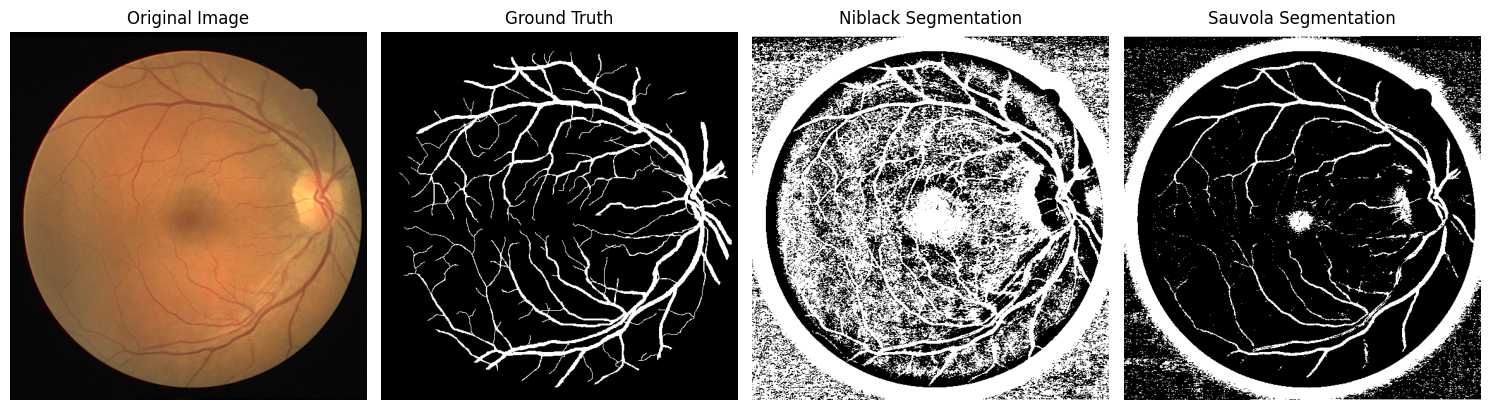


AVERAGE RESULTS ON DRIVE TRAINING SET

NIBLACK:
Sensitivity : 0.9104
Specificity : 0.4039
Accuracy    : 0.4474

SAUVOLA:
Sensitivity : 0.5646
Specificity : 0.8111
Accuracy    : 0.7895


In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from sklearn.metrics import confusion_matrix


img_folder = "/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images"
gt_folder = "/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual"


def preprocess(img):
    green = img[:, :, 1]  # Extract green channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(green)
    return enhanced


def apply_niblack(image):
    thresh = threshold_niblack(image, window_size=51, k=-0.3)
    binary = image < thresh
    return binary.astype(np.uint8)

def apply_sauvola(image):
    thresh = threshold_sauvola(image, window_size=51)
    binary = image < thresh
    return binary.astype(np.uint8)


def evaluate(pred, gt):
    pred = pred.flatten()
    gt = gt.flatten()

    tn, fp, fn, tp = confusion_matrix(gt, pred, labels=[0,1]).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return sensitivity, specificity, accuracy

image_files = sorted(os.listdir(img_folder))
random_img = random.choice(image_files)

img_path = os.path.join(img_folder, random_img)
gt_name = random_img.replace("_training.tif", "_manual1.gif")
gt_path = os.path.join(gt_folder, gt_name)

print("Selected Image:", random_img)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

preprocessed = preprocess(img)

gt = cv2.imread(gt_path, 0)
gt_binary = (gt > 0).astype(np.uint8)

niblack_seg = apply_niblack(preprocessed)
sauvola_seg = apply_sauvola(preprocessed)

plt.figure(figsize=(15,6))

plt.subplot(1,4,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(gt_binary, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(niblack_seg, cmap="gray")
plt.title("Niblack Segmentation")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(sauvola_seg, cmap="gray")
plt.title("Sauvola Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()


niblack_scores = []
sauvola_scores = []

for img_name in image_files:

    img_path = os.path.join(img_folder, img_name)
    gt_name = img_name.replace("_training.tif", "_manual1.gif")
    gt_path = os.path.join(gt_folder, gt_name)

    img = cv2.imread(img_path)
    img = preprocess(img)

    gt = cv2.imread(gt_path, 0)
    gt = (gt > 0).astype(np.uint8)

    pred_niblack = apply_niblack(img)
    pred_sauvola = apply_sauvola(img)

    niblack_scores.append(evaluate(pred_niblack, gt))
    sauvola_scores.append(evaluate(pred_sauvola, gt))

niblack_avg = np.mean(niblack_scores, axis=0)
sauvola_avg = np.mean(sauvola_scores, axis=0)

print("\nAVERAGE RESULTS ON DRIVE TRAINING SET\n")

print("NIBLACK:")
print(f"Sensitivity : {niblack_avg[0]:.4f}")
print(f"Specificity : {niblack_avg[1]:.4f}")
print(f"Accuracy    : {niblack_avg[2]:.4f}")

print("\nSAUVOLA:")
print(f"Sensitivity : {sauvola_avg[0]:.4f}")
print(f"Specificity : {sauvola_avg[1]:.4f}")
print(f"Accuracy    : {sauvola_avg[2]:.4f}")